<a href="https://colab.research.google.com/github/MohammadAghaei1/Generative-AI/blob/main/GANs_%26_VAEs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Libraries**

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import time

# **Loading dataset**

In [2]:
# LOAD AND PREPROCESS DATA
print("Loading MNIST data...")
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()

# Reshape from (60000, 28, 28) → (60000, 28, 28, 1)
# Add channel dimension for Conv2D (1 = grayscale)
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')

# Normalize pixel values from [0, 255] → [-1, 1]
train_images = (train_images - 127.5) / 127.5

# Dataset parameters
BUFFER_SIZE = 60000
BATCH_SIZE = 128

#  - shuffle it
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE)

# Check the shape of the data
print(train_dataset.shape)

**Checking activation of GPU**

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cuda


# **Making Generator**

In [ ]:
'''def build_generator():

    model = Sequential()


    model.add(Dense(128 * 7 * 7, activation="relu", input_dim=100))
    model.add(Reshape((7, 7, 128)))

    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(UpSampling2D())
    model.add(Conv2D(64, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(Conv2D(1, kernel_size=3, padding="same"))
    model.add(Activation("tanh"))

    model.summary()

    noise = Input(shape=(100,))
    img = model(noise)

    return Model(noise, img)'''

'def build_generator():\n\n    model = Sequential()\n\n\n    model.add(Dense(128 * 7 * 7, activation="relu", input_dim=100))\n    model.add(Reshape((7, 7, 128)))\n\n    model.add(UpSampling2D())\n    model.add(Conv2D(128, kernel_size=3, padding="same"))\n    model.add(BatchNormalization(momentum=0.8))\n    model.add(Activation("relu"))\n\n    model.add(UpSampling2D())\n    model.add(Conv2D(64, kernel_size=3, padding="same"))\n    model.add(BatchNormalization(momentum=0.8))\n    model.add(Activation("relu"))\n\n    model.add(Conv2D(1, kernel_size=3, padding="same"))\n    model.add(Activation("tanh"))\n\n    model.summary()\n\n    noise = Input(shape=(100,))\n    img = model(noise)\n\n    return Model(noise, img)'

In [ ]:
def build_generator():
    model = Sequential()

    # Start with a dense layer that outputs a 7x7x128 tensor
    model.add(Dense(128 * 7 * 7, input_dim=100))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Reshape((7, 7, 128)))  # Reshape to (7, 7, 128)

    # Upsample to 14x14
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    # Upsample to 28x28
    model.add(Conv2DTranspose(64, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    # Final layer to get the output to 28x28x1
    model.add(Conv2DTranspose(1, kernel_size=3, strides=1, padding='same', activation='tanh'))

    noise = Input(shape=(100,))
    img = model(noise)

    return Model(noise, img)


# **Making Discriminator**

In [ ]:
'''def build_discriminator():

    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=(28,28,1), padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0, 1), (0, 1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    model.summary()

    img = Input(shape=(28,28,1))
    validity = model(img)
    return Model(img, validity)'''

'def build_discriminator():\n\n    model = Sequential()\n\n    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=(28,28,1), padding="same"))\n    model.add(LeakyReLU(alpha=0.2))\n    model.add(Dropout(0.25))\n\n    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))\n    model.add(ZeroPadding2D(padding=((0, 1), (0, 1))))\n    model.add(BatchNormalization(momentum=0.8))\n    model.add(LeakyReLU(alpha=0.2))\n    model.add(Dropout(0.25))\n\n    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))\n    model.add(BatchNormalization(momentum=0.8))\n    model.add(LeakyReLU(alpha=0.2))\n    model.add(Dropout(0.25))\n\n    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))\n    model.add(BatchNormalization(momentum=0.8))\n    model.add(LeakyReLU(alpha=0.2))\n    model.add(Dropout(0.25))\n\n    model.add(Flatten())\n    model.add(Dense(1, activation=\'sigmoid\'))\n\n    model.summary()\n\n    img = Input(shape=(28,28,1))\n    validity = model(img)\n

In [ ]:
def build_discriminator():
    model = Sequential()

    model.add(Conv2D(64, kernel_size=3, strides=2, padding='same', input_shape=(28, 28, 1)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    img = Input(shape=(28, 28, 1))
    validity = model(img)

    return Model(img, validity)


# **Making Gan**

In [ ]:
optimizer = Adam(learning_rate=0.0002, beta_1=0.5)

# build discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# For the combined model we will only train the generator
discriminator.trainable = False

# Build the generator
generator = build_generator()

z = Input(shape=(100,))
img = generator(z)

# The discriminator takes generated images as input and determines validity
valid = discriminator(img)

# The combined model  (stacked generator and discriminator)
# Trains the generator to fool the discriminator
combined = Model(inputs=z, outputs=valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
combined.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_18 (Functional)      │ (None, 28, 28, 1)      │       881,281 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_6 (Functional)       │ (None, 1)              │        80,769 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 962,050 (3.67 MB)

 Trainable params: 868,353 (3.31 MB)

 Non-trainable params: 93,697 (366.00 KB)

# **Traning**

In [ ]:
def train(epochs, batch_size=128, save_interval=50):

    os.makedirs('images', exist_ok=True)

    latent_dim = 100

    # Adversarial ground truths
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        # Select a random real images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_imgs = X_train[idx]

        # Sample noise and generate a batch of fake images
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        fake_imgs = generator.predict(noise)

        # Train the discriminator
        D_loss_real = discriminator.train_on_batch(real_imgs, valid)
        D_loss_fake = discriminator.train_on_batch(fake_imgs, fake)
        D_loss = 0.5 * np.add(D_loss_real, D_loss_fake)

        # Train the generator
        g_loss = combined.train_on_batch(noise, valid)

        '''# printing progress
        print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %(epoch, D_loss[0], 100*D_loss[1], g_loss))

        if epoch % save_interval == 0:
            plot_generated_images(epoch, generator)'''

            # If at save interval
        if epoch % save_interval == 0:
            # Print the progress
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, D_loss[0], 100 * D_loss[1], g_loss))
            # Save generated image samples
            save_imgs(epoch)


# **visualizing**

In [ ]:
def save_imgs(epoch):

    latent_dim = 100
    r, c = 5, 5

    noise = np.random.normal(0, 1, (r * c, latent_dim))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    fig.savefig("images/mnist_%d.png" % epoch)
    plt.close()

In [ ]:
'''def plot_generated_images(epoch, generator, examples=100, dim=(10, 10),figsize=(10, 10)):

    latent_dim = 100

    noise = np.random.normal(0, 1, size=[examples, latent_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)

    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)'''

"def plot_generated_images(epoch, generator, examples=100, dim=(10, 10),figsize=(10, 10)):\n   \n    latent_dim = 100\n    \n    noise = np.random.normal(0, 1, size=[examples, latent_dim])\n    generated_images = generator.predict(noise)\n    generated_images = generated_images.reshape(examples, 28, 28)\n\n    plt.figure(figsize=figsize)\n\n    for i in range(generated_images.shape[0]):\n        plt.subplot(dim[0], dim[1], i+1)\n        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')\n        plt.axis('off')\n\n    plt.tight_layout()\n    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)"

# **Modeling**

In [ ]:
start = time.time()

train(epochs=10000, batch_size=32, save_interval=100)

end = time.time()
elapsed_train_time = 'elapsed training time: {} min, {} sec '.format(int((end - start) / 60),
                                                                     int((end - start) % 60))
print(elapsed_train_time)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py:83: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


0 [D loss: 0.715158, acc.: 24.22%] [G loss: 0.722831]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/

In [ ]:
os.makedirs('saved_model_weights', exist_ok=True)
generator.save_weights('saved_model_weights/generator_weights.h5')
discriminator.save_weights('saved_model_weights/discriminator_weights.h5')
combined.save_weights('saved_model_weights/combined_weights.h5')

In [ ]:
Image.open('images/mnist_1000.png')

In [ ]:
Image.open('images/mnist_9000.png')

# **Gan**

Loading MNIST data...
Starting training with Tanh [-1, 1]...
Epoch 1, Gen Loss: 2.5249, Disc Loss: 0.3210


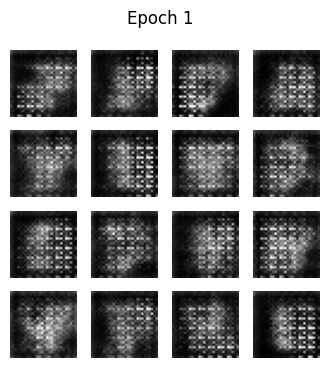

Epoch 2, Gen Loss: 1.3175, Disc Loss: 0.8264


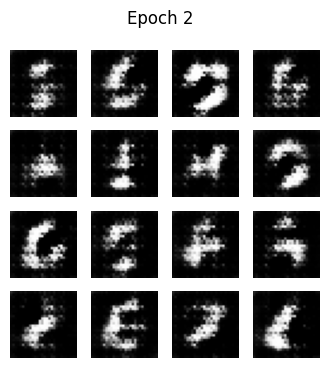

Epoch 3, Gen Loss: 1.4076, Disc Loss: 0.8783


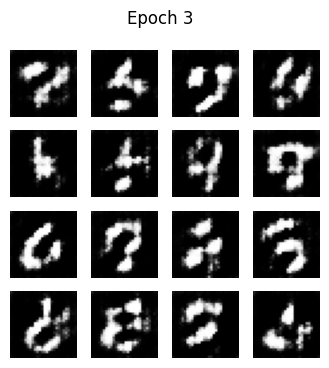

Epoch 4, Gen Loss: 1.2243, Disc Loss: 1.0557


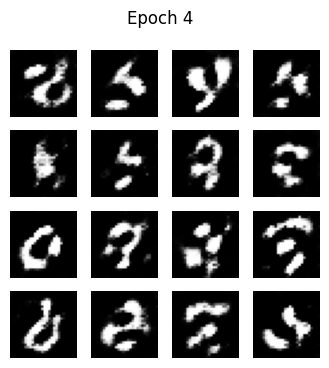

Epoch 5, Gen Loss: 1.1175, Disc Loss: 1.0781


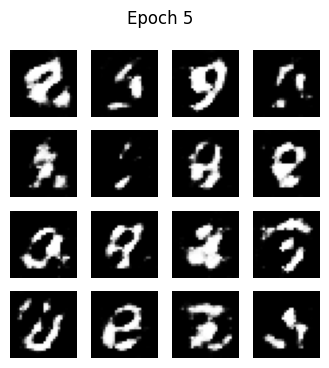

Epoch 6, Gen Loss: 1.1578, Disc Loss: 1.0433


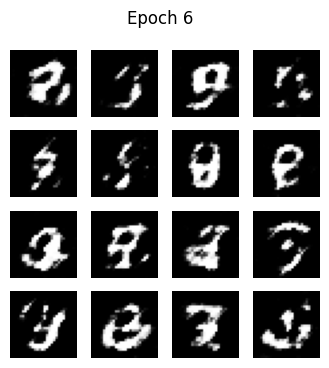

Epoch 7, Gen Loss: 1.1935, Disc Loss: 1.0472


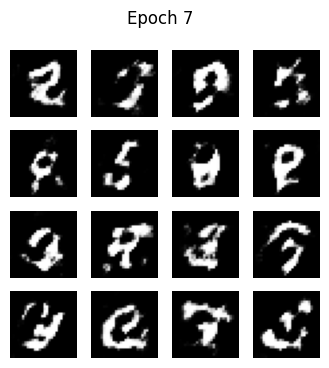

Epoch 8, Gen Loss: 1.2132, Disc Loss: 1.0266


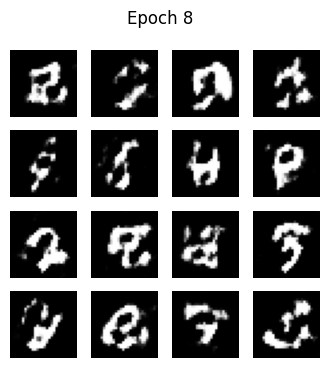

Epoch 9, Gen Loss: 1.3107, Disc Loss: 0.9505


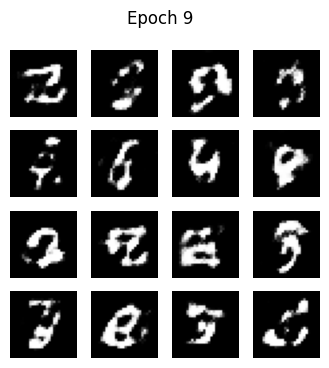

Epoch 10, Gen Loss: 1.3930, Disc Loss: 0.9153


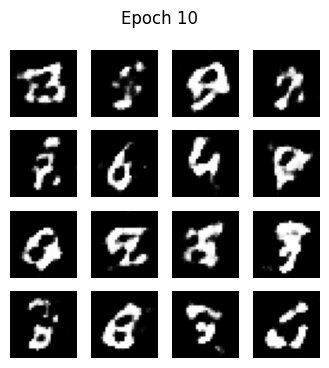

Epoch 11, Gen Loss: 1.4911, Disc Loss: 0.8572


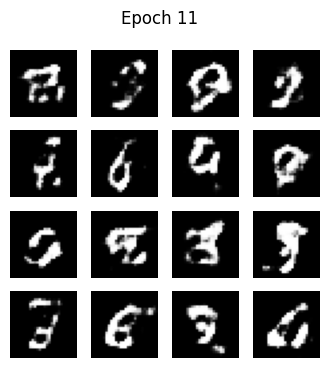

Epoch 12, Gen Loss: 1.6144, Disc Loss: 0.7969


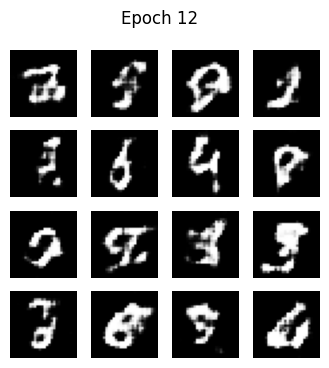

Epoch 13, Gen Loss: 1.7679, Disc Loss: 0.7864


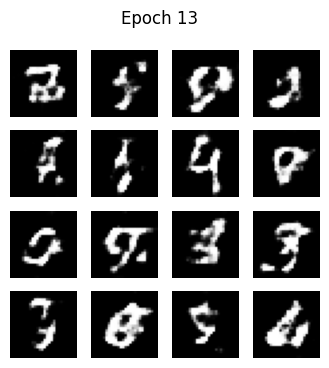

Epoch 14, Gen Loss: 1.7597, Disc Loss: 0.7612


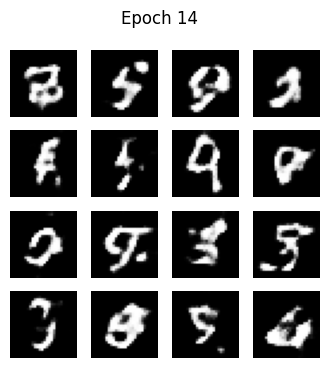

Epoch 15, Gen Loss: 1.7632, Disc Loss: 0.8017


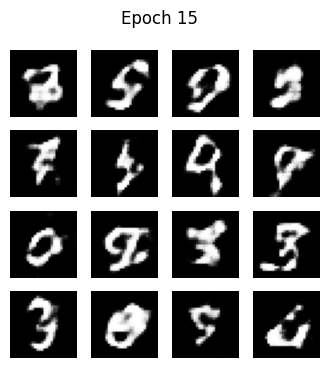

Epoch 16, Gen Loss: 1.7230, Disc Loss: 0.8441


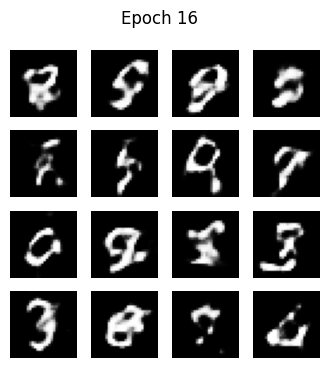

Epoch 17, Gen Loss: 1.6301, Disc Loss: 0.8740


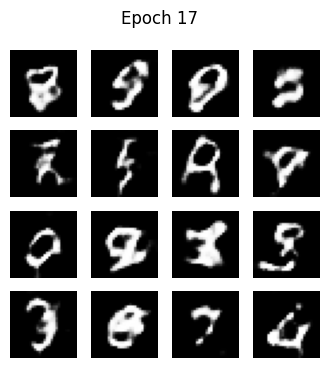

Epoch 18, Gen Loss: 1.5931, Disc Loss: 0.9195


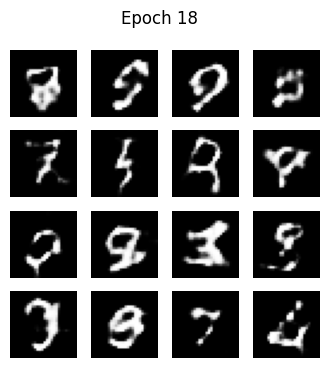

Epoch 19, Gen Loss: 1.5379, Disc Loss: 0.9452


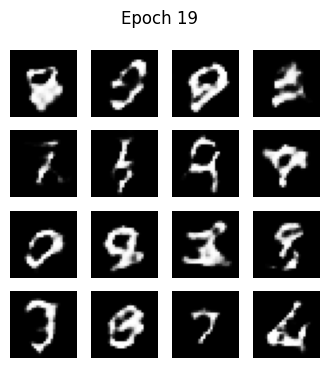

Epoch 20, Gen Loss: 1.5510, Disc Loss: 0.9448


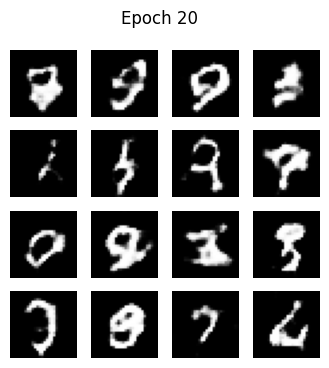

Epoch 21, Gen Loss: 1.4884, Disc Loss: 0.9610


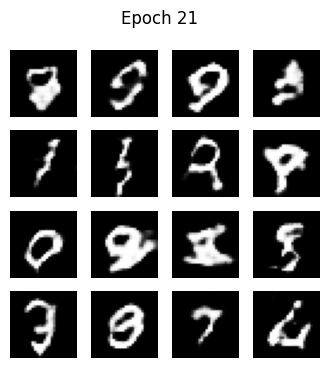

Epoch 22, Gen Loss: 1.3890, Disc Loss: 0.9853


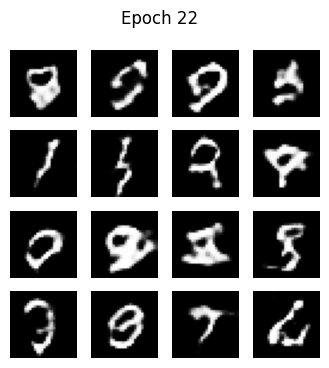

Epoch 23, Gen Loss: 1.4041, Disc Loss: 0.9939


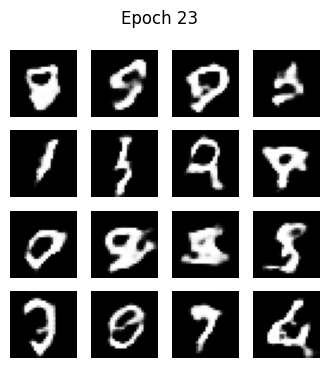

Epoch 24, Gen Loss: 1.4050, Disc Loss: 1.0170


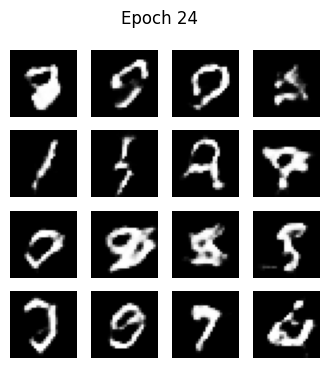

Epoch 25, Gen Loss: 1.3732, Disc Loss: 1.0097


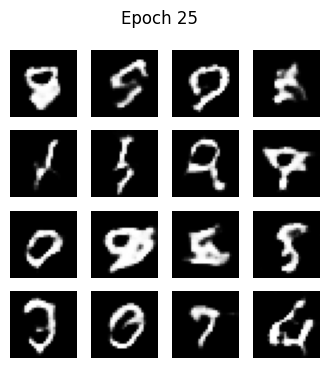

Epoch 26, Gen Loss: 1.3235, Disc Loss: 1.0272


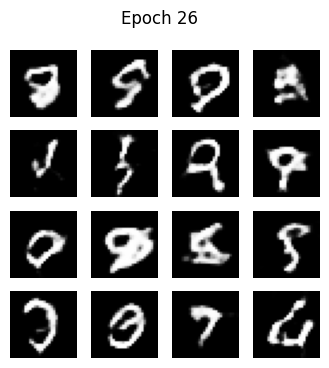

Epoch 27, Gen Loss: 1.2982, Disc Loss: 1.0357


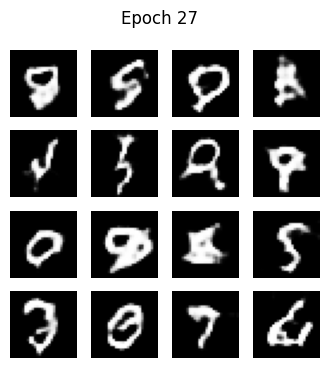

Epoch 28, Gen Loss: 1.3870, Disc Loss: 1.0254


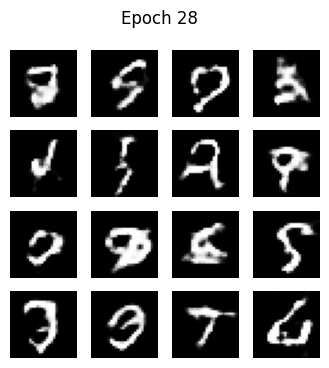

Epoch 29, Gen Loss: 1.3340, Disc Loss: 1.0397


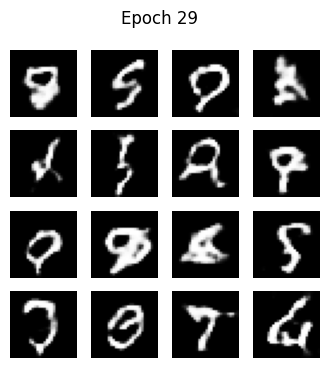

Epoch 30, Gen Loss: 1.2678, Disc Loss: 1.0503


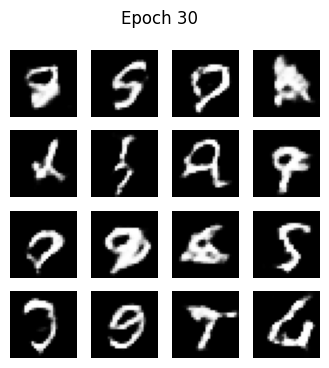

Epoch 31, Gen Loss: 1.2867, Disc Loss: 1.0456


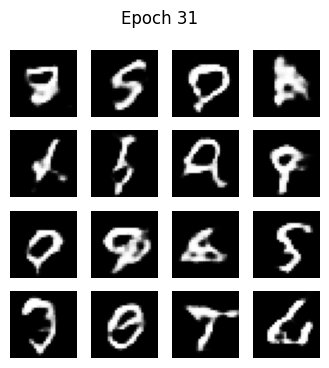

Epoch 32, Gen Loss: 1.2919, Disc Loss: 1.0501


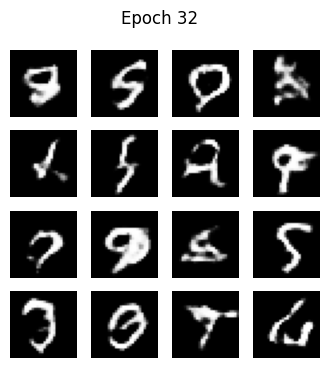

Epoch 33, Gen Loss: 1.2840, Disc Loss: 1.0591


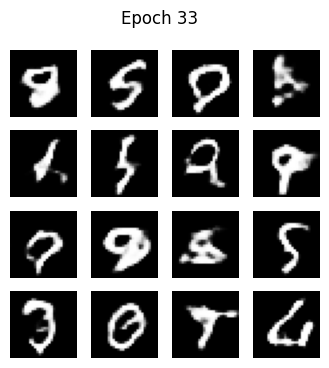

Epoch 34, Gen Loss: 1.2700, Disc Loss: 1.0567


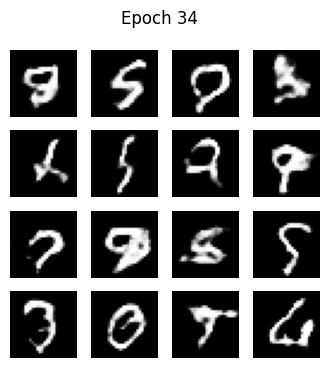

Epoch 35, Gen Loss: 1.2295, Disc Loss: 1.0684


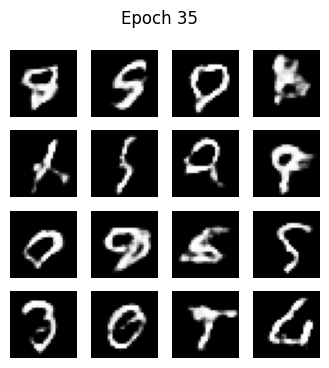

Epoch 36, Gen Loss: 1.2314, Disc Loss: 1.0665


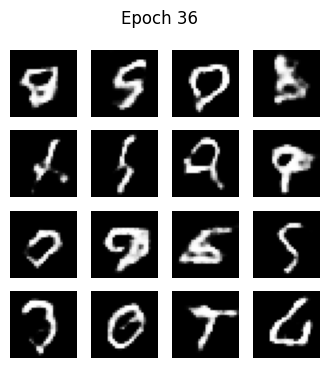

Epoch 37, Gen Loss: 1.2263, Disc Loss: 1.0711


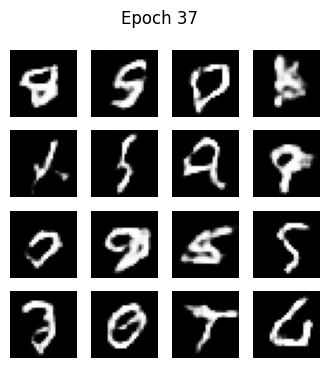

Epoch 38, Gen Loss: 1.2622, Disc Loss: 1.0642


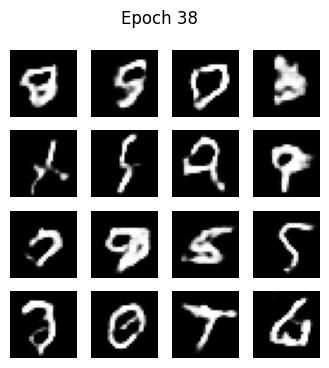

Epoch 39, Gen Loss: 1.2548, Disc Loss: 1.0670


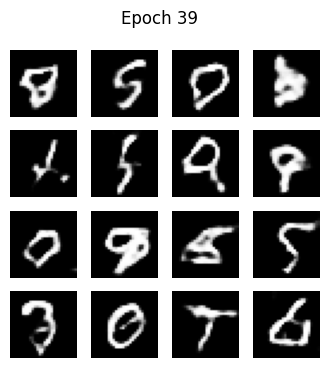

Epoch 40, Gen Loss: 1.2166, Disc Loss: 1.0737


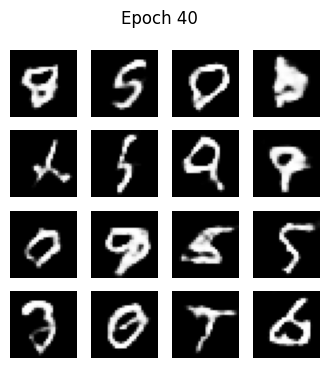

Epoch 41, Gen Loss: 1.2109, Disc Loss: 1.0795


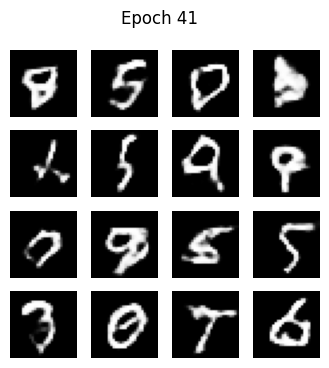

Epoch 42, Gen Loss: 1.2279, Disc Loss: 1.0689


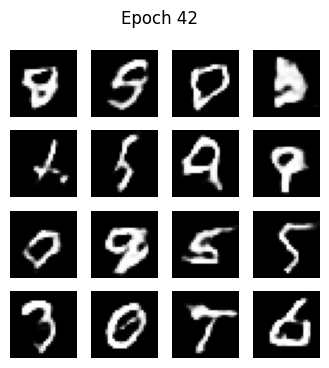

Epoch 43, Gen Loss: 1.2507, Disc Loss: 1.0749


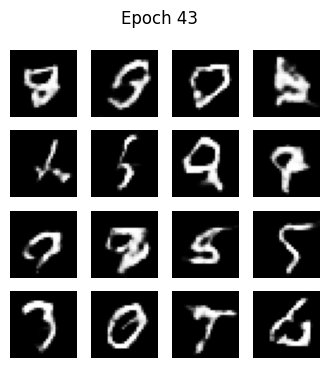

Epoch 44, Gen Loss: 1.2354, Disc Loss: 1.0673


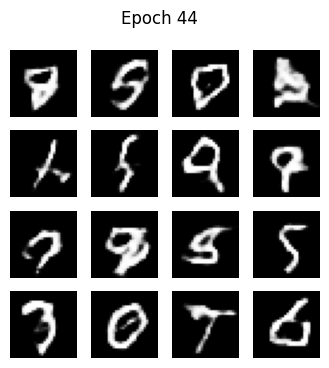

Epoch 45, Gen Loss: 1.2246, Disc Loss: 1.0756


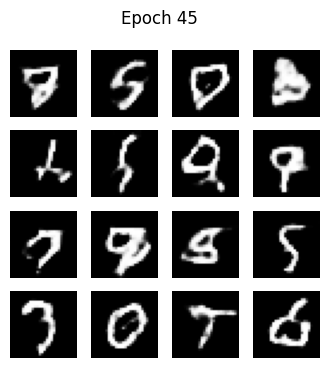

Epoch 46, Gen Loss: 1.2556, Disc Loss: 1.0674


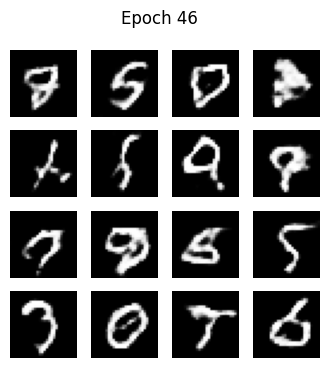

Epoch 47, Gen Loss: 1.2244, Disc Loss: 1.0727


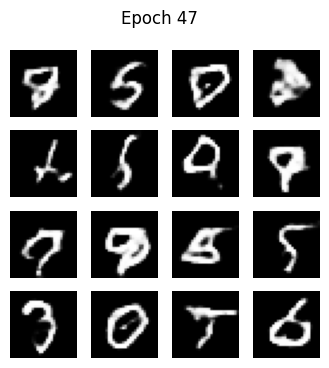

Epoch 48, Gen Loss: 1.1984, Disc Loss: 1.0715


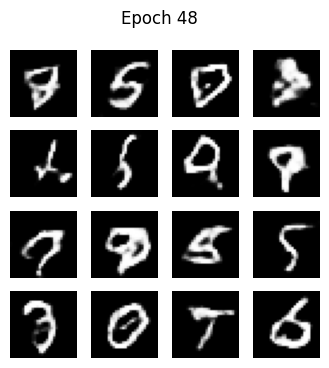

Epoch 49, Gen Loss: 1.2376, Disc Loss: 1.0707


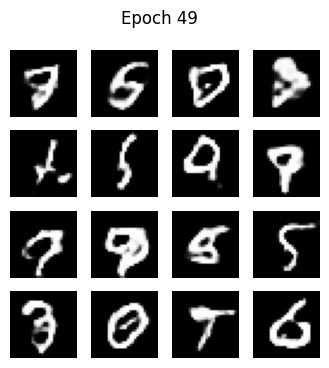

Epoch 50, Gen Loss: 1.2486, Disc Loss: 1.0694


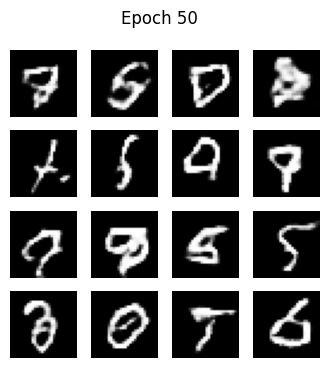

In [8]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import time

# 1. LOAD AND PREPROCESS DATA (CHANGED)
def load_data():
    print("Loading MNIST data...")
    (train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

    # Reshape
    train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')

    # CHANGE: Normalize to [-1, 1] instead of [0, 1]
    train_images = (train_images - 127.5) / 127.5

    BUFFER_SIZE = 60000
    BATCH_SIZE = 128
    train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    return train_dataset

# 2. BUILD THE GENERATOR (CHANGED)
def make_generator_model(noise_dim):
    model = tf.keras.Sequential()

    model.add(layers.Dense(7*7*128, use_bias=False, input_shape=(noise_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((7, 7, 128)))

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # CHANGE: Activation is 'tanh' to output range [-1, 1]
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

# 3. BUILD THE DISCRIMINATOR (Same as before)
def make_discriminator_model():
    model = tf.keras.Sequential()

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())

    # We keep Sigmoid here because the discriminator still predicts a probability (0=fake, 1=real)
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

# 4. LOSSES
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# 5. INITIALIZE
NOISE_DIM = 100
generator = make_generator_model(NOISE_DIM)
discriminator = make_discriminator_model()

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# 6. TRAINING STEP
@tf.function
def train_step(images):
    noise = tf.random.normal([128, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

# 7. VISUALIZATION FUNCTION (CHANGED)
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)

        # CHANGE: Rescale [-1, 1] back to [0, 1] for plotting
        # formula: (x * 127.5 + 127.5) / 255.0  <-- effectively (x + 1) / 2
        img_to_plot = (predictions[i, :, :, 0] + 1) / 2.0

        plt.imshow(img_to_plot, cmap='gray')
        plt.axis('off')

    plt.suptitle(f'Epoch {epoch}')
    plt.show()

# 8. MAIN TRAIN LOOP
def train(dataset, epochs):
    print("Starting training with Tanh [-1, 1]...")
    for epoch in range(epochs):
        start = time.time()

        g_loss_metric = 0
        d_loss_metric = 0
        steps = 0

        for image_batch in dataset:
            g_loss, d_loss = train_step(image_batch)
            g_loss_metric += g_loss
            d_loss_metric += d_loss
            steps += 1

        print(f'Epoch {epoch + 1}, Gen Loss: {g_loss_metric/steps:.4f}, Disc Loss: {d_loss_metric/steps:.4f}')

        generate_and_save_images(generator, epoch + 1, seed)

# --- EXECUTION ---
seed = tf.random.normal([16, NOISE_DIM])
train_dataset = load_data()
train(train_dataset, epochs=50)

In [8]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import time

# 1. LOAD AND PREPROCESS DATA (CHANGED)
print("Loading MNIST data...")
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()

# Reshape
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')

# Normalize to [-1, 1]
train_images = (train_images - 127.5) / 127.5

# Same parameters as before
BUFFER_SIZE = 60000
BATCH_SIZE = 128

# Create shuffled dataset (UNBATCHED – batching will be in train())
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE)

# 2. BUILD THE GENERATOR (CHANGED)
def make_generator_model(noise_dim):
    model = tf.keras.Sequential()

    model.add(layers.Dense(7*7*128, use_bias=False, input_shape=(noise_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((7, 7, 128)))

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # CHANGE: Activation is 'tanh' to output range [-1, 1]
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

# 3. BUILD THE DISCRIMINATOR (Same as before)
def make_discriminator_model():
    model = tf.keras.Sequential()

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())

    # We keep Sigmoid here because the discriminator still predicts a probability (0=fake, 1=real)
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

# 4. LOSSES
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# 5. INITIALIZE
NOISE_DIM = 100
generator = make_generator_model(NOISE_DIM)
discriminator = make_discriminator_model()

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# 6. TRAINING STEP
@tf.function
def train_step(images):
    noise = tf.random.normal([128, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    # ----- NEW: discriminator accuracies -----
    # real images → label = 1 → correct if output > 0.5
    real_pred = tf.cast(real_output > 0.5, tf.float32)  # 1 if predicted real
    real_acc = tf.reduce_mean(real_pred)  # fraction correctly real

    # fake images → label = 0 → correct if output <= 0.5
    fake_pred_real = tf.cast(fake_output > 0.5, tf.float32)  # 1 if predicted real (wrong)
    fake_acc = tf.reduce_mean(1.0 - fake_pred_real)  # 1 - wrong = correct

    return gen_loss, disc_loss, real_acc, fake_acc

# 7. VISUALIZATION FUNCTION (CHANGED)
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)

        # CHANGE: Rescale [-1, 1] back to [0, 1] for plotting
        # formula: (x * 127.5 + 127.5) / 255.0  <-- effectively (x + 1) / 2
        img_to_plot = (predictions[i, :, :, 0] + 1) / 2.0

        plt.imshow(img_to_plot, cmap='gray')
        plt.axis('off')

    plt.suptitle(f'Epoch {epoch}')
    plt.show()

# 8. MAIN TRAIN LOOP
def train(dataset, epochs):
    print("Starting training with Tanh [-1, 1]...")

    # If you are batching here:
    BATCH_SIZE = 128
    dataset = dataset.batch(BATCH_SIZE)

    for epoch in range(epochs):
        g_loss_metric = 0
        d_loss_metric = 0
        real_acc_metric = 0
        fake_acc_metric = 0
        steps = 0

        for image_batch in dataset:
            g_loss, d_loss, real_acc, fake_acc = train_step(image_batch)
            g_loss_metric += g_loss
            d_loss_metric += d_loss
            real_acc_metric += real_acc
            fake_acc_metric += fake_acc
            steps += 1

        avg_g_loss = g_loss_metric / steps
        avg_d_loss = d_loss_metric / steps
        avg_real_acc = real_acc_metric / steps
        avg_fake_acc = fake_acc_metric / steps

        # Print losses + percentages
        print(
            f'Epoch {epoch + 1}, '
            f'Gen Loss: {avg_g_loss:.4f}, '
            f'Disc Loss: {avg_d_loss:.4f}, '
            f'D(real)%: {avg_real_acc * 100:.1f}, '
            f'D(fake)%: {avg_fake_acc * 100:.1f}'
        )

        # 🔹 THIS is your visualization line
        generate_and_save_images(generator, epoch + 1, seed)

# --- EXECUTION ---
seed = tf.random.normal([16, NOISE_DIM])
train(train_dataset, epochs=50)

Loading MNIST data...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Starting training with Tanh [-1, 1]...


KeyboardInterrupt: 